In [1]:
import sys
sys.path.append('../../MembraneQuant')
from membranequant import *
%matplotlib notebook

In [2]:
basepath = '/Users/blandt/Desktop/Data/PAR2 RING mutants experiment 2/Experiment'
paths = direcslist(basepath, 1)
conditions = [p.split('/')[-2].split('_')[1] for p in paths]

imgs = [load_image(p + '/af_corrected.tif') for p in paths]
imgs_flat = [load_image(p + '/af_corrected_flat.tif') for p in paths]
imgs_3channel = [load_image(p + '/af_corrected_3channel.tif') for p in paths]
imgs_3channel_flat = [load_image(p + '/af_corrected_3channel_flat.tif') for p in paths]

rois = [np.loadtxt(p + '/ROI_fit.txt') for p in paths]
cytbg = np.loadtxt('../T2A/cytbg.txt')

imgs = [i for i, c in zip(imgs, conditions) if c == 'nwg325']
rois = [r for r, c in zip(rois, conditions) if c == 'nwg325']

In [3]:
iq = ImageQuant(img=imgs[0], roi=rois[0], cytbg=cytbg, uni_cyt=True, adaptive_membg=True, 
                batch_norm=False, descent_steps=300, rol_ave=5, lr=0.01, iterations=1, rotate=False,
                interp_type='cubic', roi_knots=20, save_training=True, sigma=2, save_sims=True)
iq.run()

100%|██████████| 300/300 [00:10<00:00, 28.45it/s]


Time elapsed: 10.65 seconds 


<IPython.core.display.Javascript object>


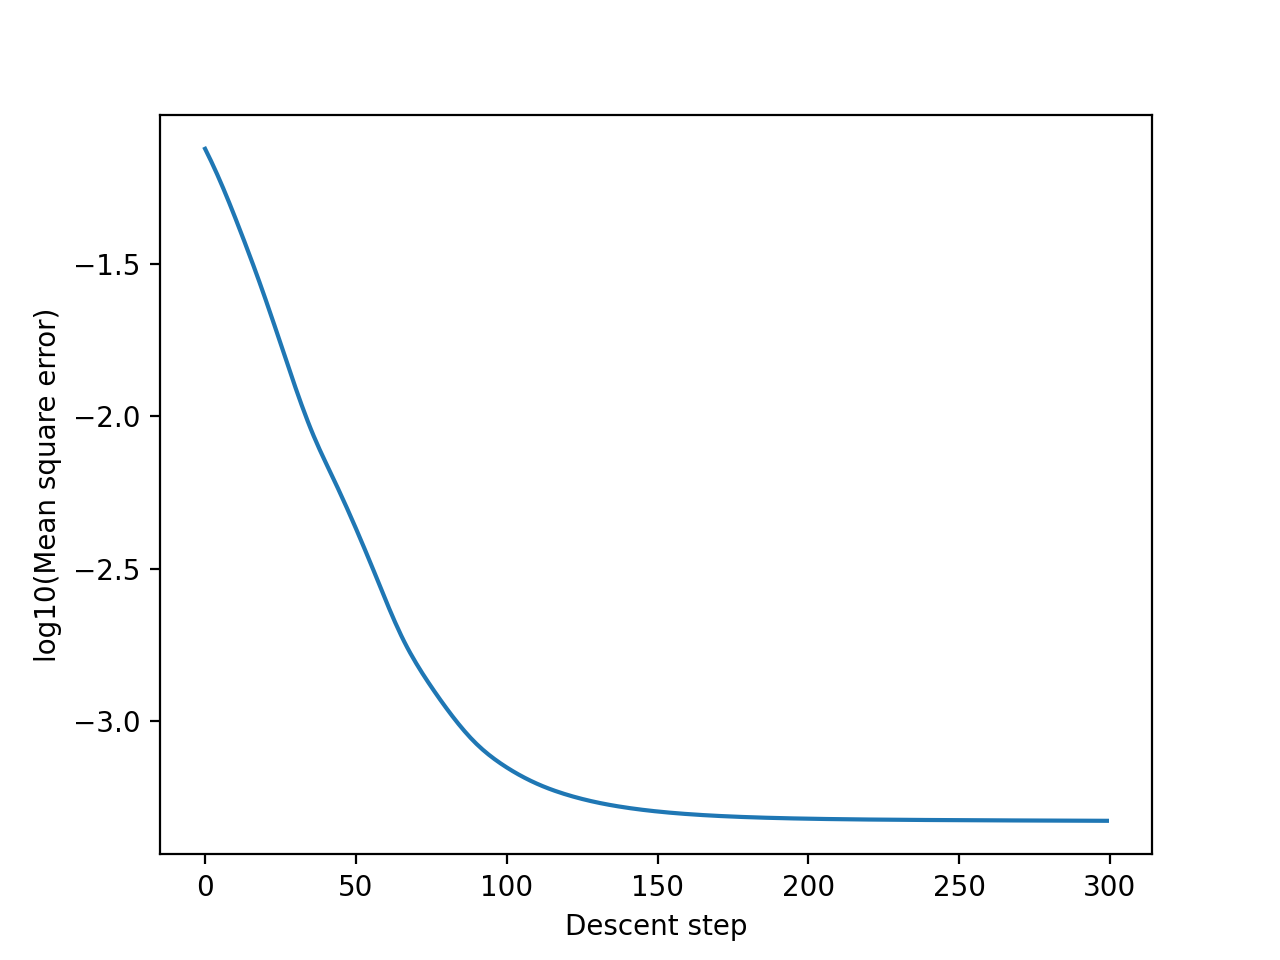

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

In [4]:
iq.plot_losses(log=True)

<IPython.core.display.Javascript object>


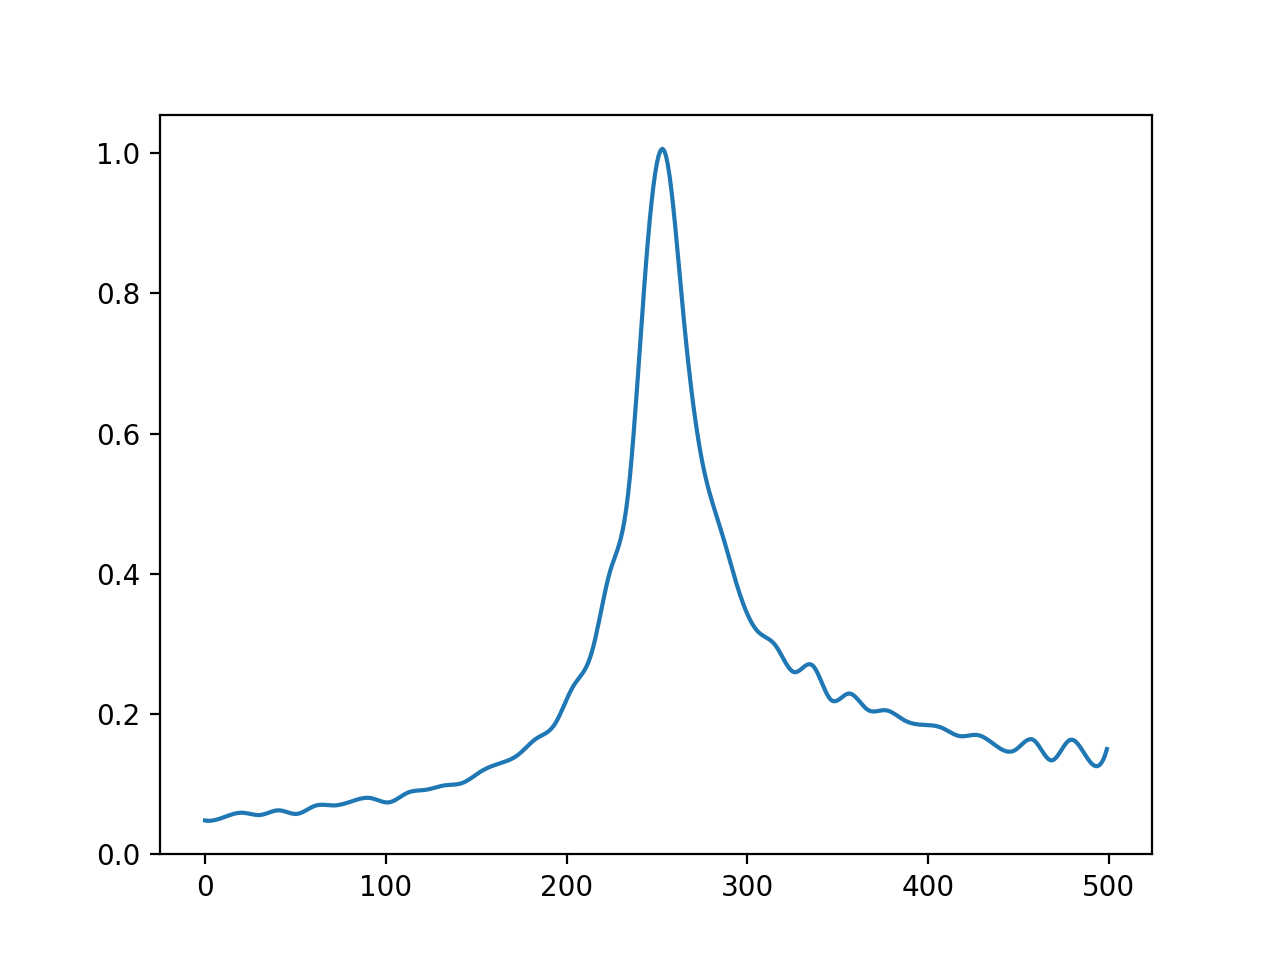

In [5]:
fig, ax = plt.subplots()
ax.plot(interp_1d_array(iq.membg / max(iq.membg), 500))

### Membg training

<IPython.core.display.Javascript object>


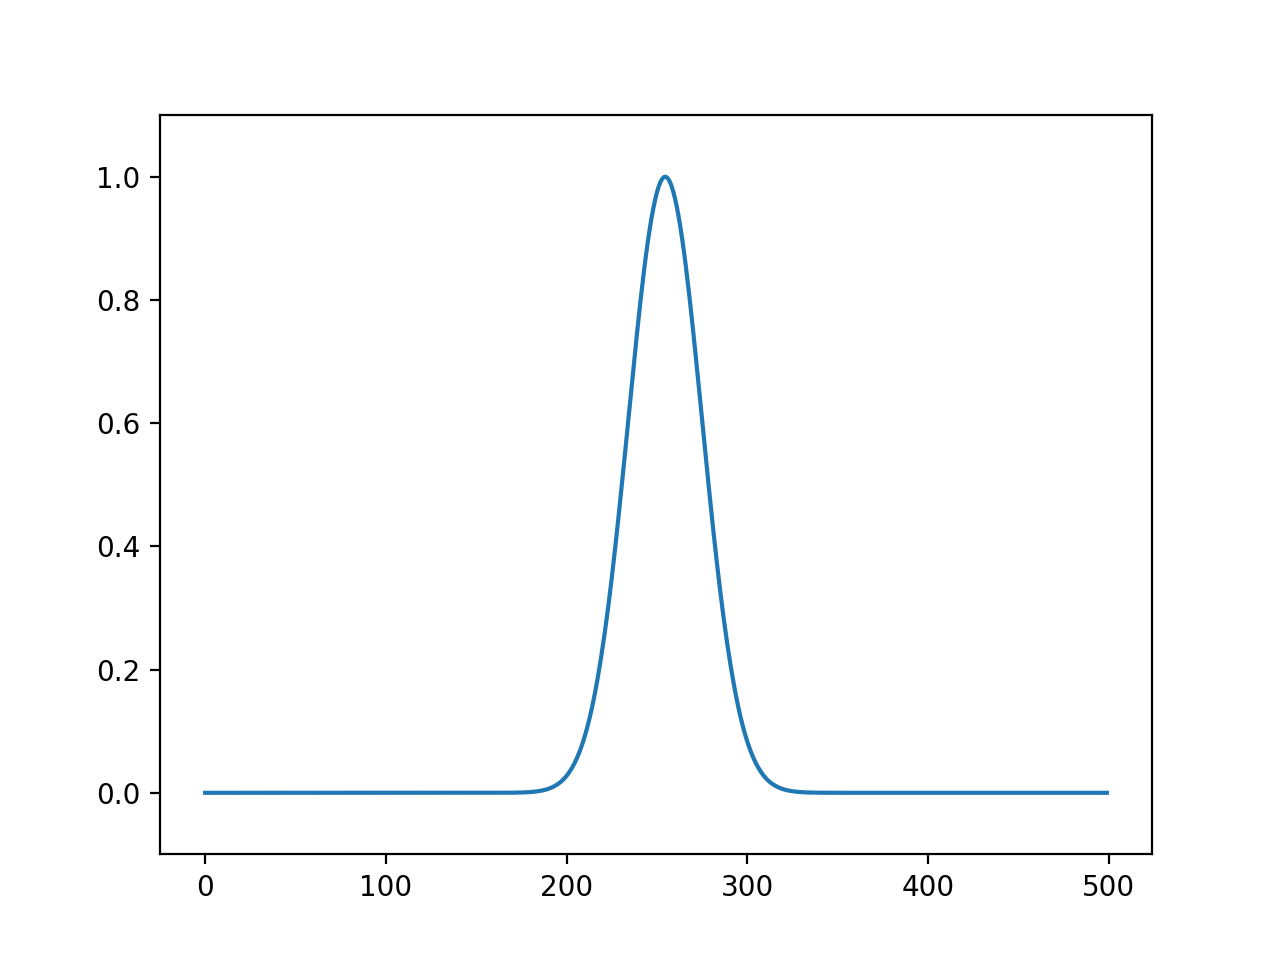

interactive(children=(IntSlider(value=0, description='i', max=299), Output()), _dom_classes=('widget-interact'…

In [6]:
import ipywidgets as widgets

fig, ax = plt.subplots()
@widgets.interact(i=(0, len(iq.saved_vars) - 1, 1))
def update(i=0): 
    ax.clear()
    _membg = iq.saved_vars[i]['membg']
    _membg_interp = interp_1d_array(_membg, 500)
    ax.plot(_membg_interp / max(_membg_interp))
    ax.set_ylim(-0.1, 1.1)

In [ ]:
timepoints = np.linspace(0, 250, 100, dtype=int)

def lighten(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

<IPython.core.display.Javascript object>


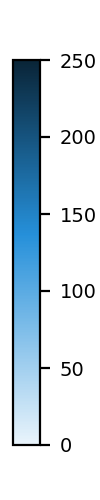

In [54]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

all_colours = [lighten('tab:blue', 2.3 - 2 * (i / 250)) for i in timepoints]
cmap = LinearSegmentedColormap.from_list('', all_colours, N=250)

fig, ax = plt.subplots(figsize=(1.5, 4))
fig.subplots_adjust(right=0.4)
n = 251
norm = matplotlib.colors.BoundaryNorm(np.arange(0, n), n)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, ticks=np.arange(0, n + 1, 50))
cbar.ax.tick_params(labelsize=7)
fig.set_size_inches(0.5,2.5)
fig.savefig('Figs_membg/cbar.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


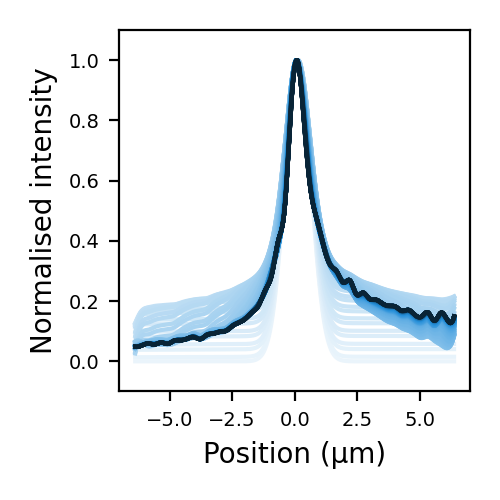

In [51]:
fig, ax = plt.subplots()
for i in timepoints:
    _membg = iq.saved_vars[i]['membg']
    _membg_interp = interp_1d_array(_membg, 500)
    ax.plot(np.linspace(-25 * 0.255, 25 * 0.255, 500), _membg_interp / max(_membg_interp), 
            c=lighten('tab:blue', 2.3 - 2 * (i / 250)))
    ax.set_ylim(-0.1, 1.1)
ax.tick_params(axis='both', labelsize=7)
ax.set_xlabel('Position (μm)')
ax.set_ylabel('Normalised intensity')
fig.set_size_inches(2.5, 2.5)
fig.tight_layout()
fig.savefig('Figs_membg/membg_training.png', dpi=600, transparent=True)

In [8]:
# timepoints = [0, 50, 100, 299]

# fig, ax = plt.subplots(1, 4)
# for a, t in zip(ax, timepoints):
#     _membg = iq.saved_vars[t]['membg']
#     _membg_interp = interp_1d_array(_membg, 500)
#     a.plot(_membg_interp / max(_membg_interp), c='k')
#     a.set_ylim(-0.1, 1.1)
# fig.set_size_inches(8, 2)
# fig.tight_layout()

### Mem concentration training

In [9]:
# import ipywidgets as widgets

# fig, ax = plt.subplots()
# @widgets.interact(i=(0, len(iq.saved_vars) - 1, 1))
# def update(i=0): 
#     ax.clear()
#     for j in iq.saved_vars[i]['mems']:
#         ax.plot(j)
#     ax.set_ylim(-0.1, 1)
#     ax.axhline(0, c='k', linestyle='--')

<IPython.core.display.Javascript object>


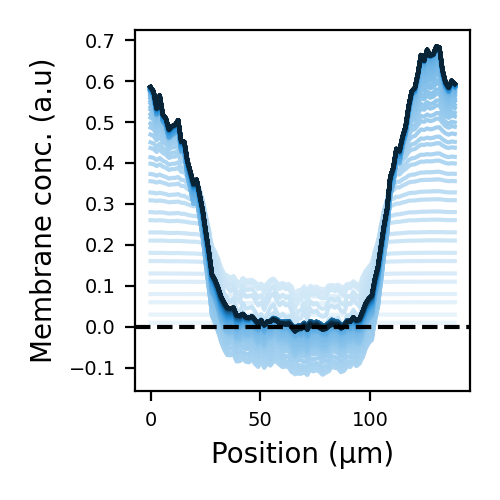

In [52]:
timepoints = np.linspace(0, 250, 100, dtype=int)
x = np.linspace(0, rois[0].shape[0] * 0.255, 100)

fig, ax = plt.subplots()
for i in timepoints:
    ax.plot(x, iq.saved_vars[i]['mems'][0], c=lighten('tab:blue', 2.3 - 2 * (i / 250)))
#     ax.set_ylim(-0.1, 1.1)
ax.tick_params(axis='both', labelsize=7)
ax.set_xlabel('Position (μm)')
ax.set_ylabel('Membrane conc. (a.u)')
ax.axhline(0, linestyle='--', c='k')
fig.set_size_inches(2.5, 2.5)
fig.tight_layout()
fig.savefig('Figs_membg/memconc_training.png', dpi=600, transparent=True)

### Cytoplasmic conc training

<IPython.core.display.Javascript object>


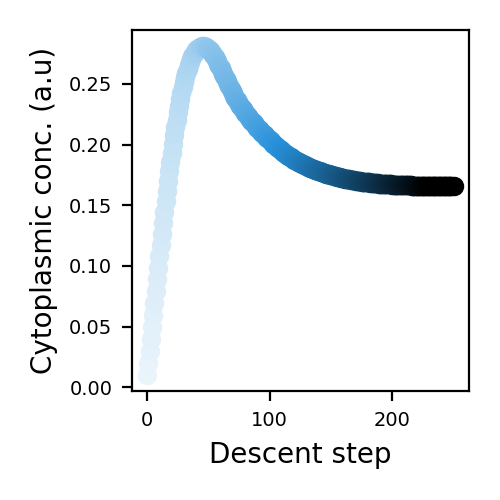

In [53]:
timepoints = np.linspace(0, 250, 250, dtype=int)

fig, ax = plt.subplots()
for i in timepoints:
    ax.scatter(i, iq.saved_vars[i]['cyts'][0], color=lighten('tab:blue', 2.3 - 2 * (i / 200)))
#     ax.set_ylim(-0.1, 1.1)
ax.tick_params(axis='both', labelsize=7)
ax.set_xlabel('Descent step')
ax.set_ylabel('Cytoplasmic conc. (a.u)')
fig.set_size_inches(2.5, 2.5)
fig.tight_layout()
fig.savefig('Figs_membg/cytconc_training.png', dpi=600, transparent=True)

### Straightened image training

In [12]:
# timepoints = [0, 50, 100, 299]

# fig, ax = plt.subplots(4, 1)
# straight_true = straighten(imgs[0], rois[0], 50)
# for a, t in zip(ax, timepoints):
#     s = iq.saved_sims[t][0, :, :]
#     s_interp = interp_2d_array(s.T, rois[0].shape[0]).T
#     print(s.shape)
# #     a.imshow(s_interp - straight_true, vmin=-10000, vmax=10000)
#     a.imshow(s_interp)
#     a.axis('off')
# # fig.set_size_inches(8, 2)
# # fig.tight_layout()

<IPython.core.display.Javascript object>


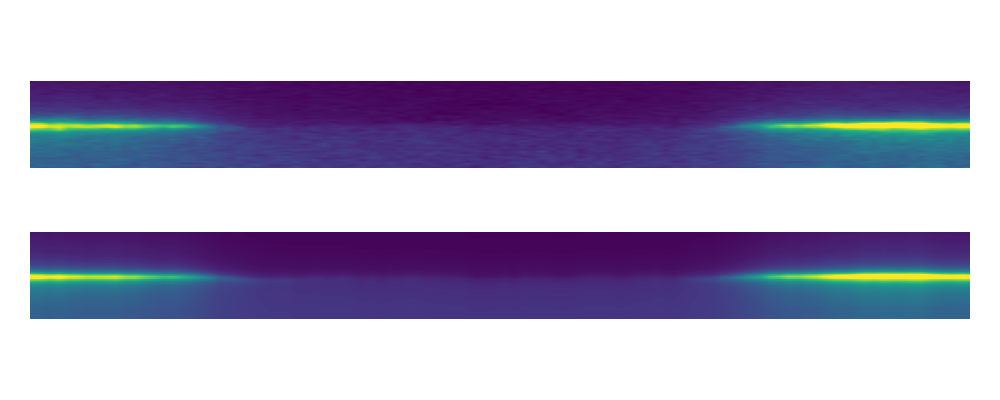

In [13]:
fig, ax = plt.subplots(2, 1)
ax[0].imshow(iq.target_full[0], vmin=0, vmax=20000)
ax[1].imshow(iq.sim_both_full[0], vmin=0, vmax=20000)
[a.axis('off') for a in ax]
fig.set_size_inches(5, 2)
fig.tight_layout()
fig.savefig('Figs_membg/sim_images.png', dpi=600, transparent=True)

### Cross sections

<IPython.core.display.Javascript object>


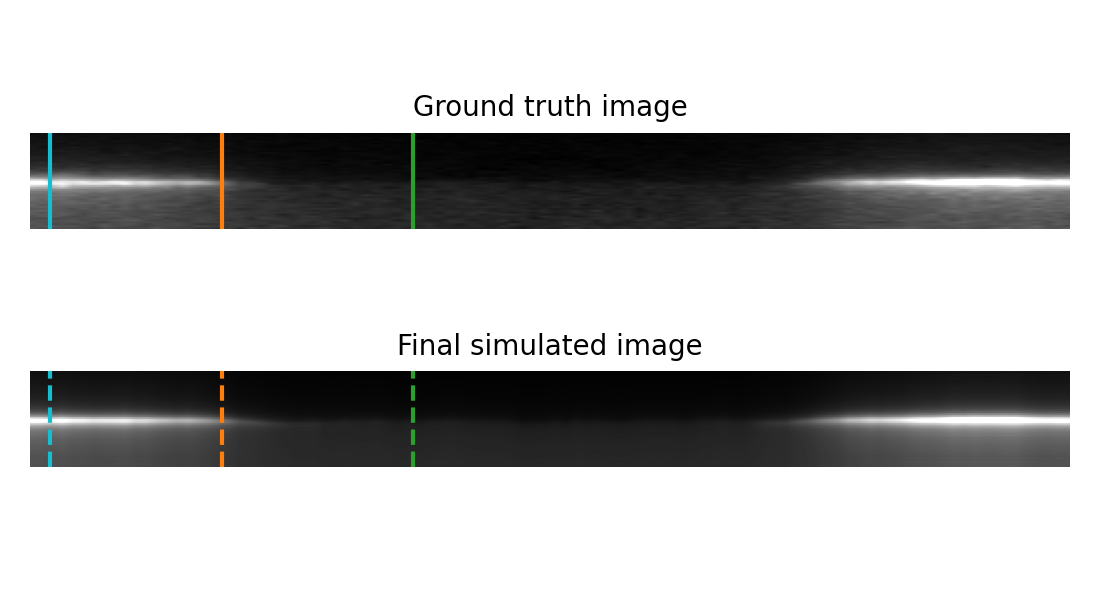

In [55]:
positions = [10, 100, 200]

fig, ax = plt.subplots(2, 1)
ax[0].imshow(iq.target_full[0], vmin=0, vmax=20000, cmap='gray')
ax[1].imshow(iq.sim_both_full[0], vmin=0, vmax=20000, cmap='gray')
[a.axis('off') for a in ax]

ax[0].axvline(positions[0], c='tab:cyan', linestyle='-')
ax[0].axvline(positions[1], c='tab:orange', linestyle='-')
ax[0].axvline(positions[2], c='tab:green', linestyle='-')

ax[1].axvline(positions[0], c='tab:cyan', linestyle='--')
ax[1].axvline(positions[1], c='tab:orange', linestyle='--')
ax[1].axvline(positions[2], c='tab:green', linestyle='--')

ax[0].set_title('Ground truth image', fontsize=10)
ax[1].set_title('Final simulated image', fontsize=10)

fig.set_size_inches(5.5, 3)
fig.tight_layout()
fig.savefig('Figs_membg/sim_images_cross_section.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


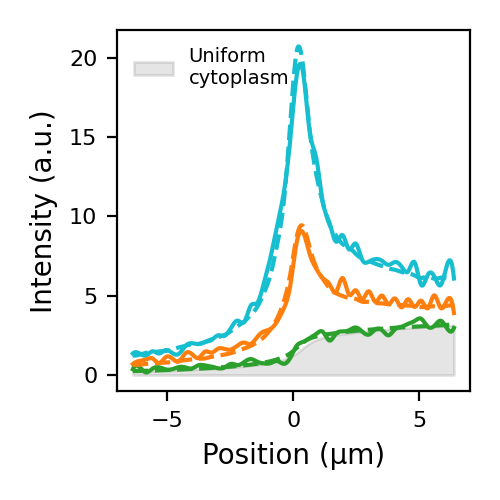

In [17]:
fig, ax = plt.subplots()

x = np.linspace(-25 * 0.255, 25 * 0.255, 500)

ax.plot(x, interp_1d_array(iq.target_full[0][:, positions[0]], 500) / 1000, c='tab:cyan')
ax.plot(x, interp_1d_array(iq.target_full[0][:, positions[1]], 500) / 1000, c='tab:orange')
ax.plot(x, interp_1d_array(iq.target_full[0][:, positions[2]], 500) / 1000, c='tab:green')

ax.plot(x, interp_1d_array(iq.sim_both_full[0][:, positions[0]], 500) / 1000, c='tab:cyan', linestyle='--')
ax.plot(x, interp_1d_array(iq.sim_both_full[0][:, positions[1]], 500) / 1000, c='tab:orange', linestyle='--')
ax.plot(x, interp_1d_array(iq.sim_both_full[0][:, positions[2]], 500) / 1000, c='tab:green', linestyle='--')

ax.fill_between(x, np.zeros(len(x)), interp_1d_array(iq.sim_cyt_full[0][:, positions[2]], 500) / 1000, color='k',
               alpha=0.1, label='Uniform\ncytoplasm')

ax.legend(frameon=False, fontsize=7)

ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel('Position (μm)')
ax.set_ylabel('Intensity (a.u.)')
fig.set_size_inches(2.5, 2.5)
fig.tight_layout()
fig.savefig('Figs_membg/cross_sections.png', dpi=600, transparent=True)